# **-> Assignment: Algo-Trading System with ML & Automation**
-----

**Submitted by:** Arnab Ghosh  


**Description:**  
This end-to-end Python prototype automates intraday trading signal generation using RSI and Moving Average crossovers, and leverages **ML models (Logistic, Random Forest, XGBoost)** for next-day stock movement prediction. The system supports real-time **Google Sheets integration**, **P&L simulation** and **Telegram alerts**.

✅ **Core Features:**
- Stock data ingestion via **Yahoo Finance API**  
- Multi-strategy buy signal generation  
- ML-based signal prediction and model comparison  
- Auto-logging to Google Sheets (trade logs, P&L, win ratios)  
- Telegram alerts for signals and pipeline status  
- Model export to Drive for future deployment

🎯 **Evaluation Criteria Covered:**
- ✔ API handling  
- ✔ Strategy logic  
- ✔ ML/Analytics  
- ✔ Sheets Automation  
- ✔ Modular, documented codebase

# **1. Data Ingestion**

In [1]:
!pip install yfinance ta pandas_ta

### **1.1 Import Libraries & Setup Logging**
We begin by importing the required libraries that support all downstream tasks including:
* Data fetching using **Yahoo Finance API (yfinance)**
* Data manipulation with Pandas and NumPy
* Date handling for historical range definitions and signal labeling
* Structured logging to monitor the process with clear INFO/ERROR outputs

In [2]:
# 📦 Import Libraries
# Yahoo Finance API for fetching stock data
import yfinance as yf

# Pandas and NumPy for data manipulation
import pandas as pd
import numpy as np

# datetime for date handling in backtesting and range selection
import datetime
# logging module for structured log output (INFO, ERROR, etc.)
import logging

# ⚙️ Setup logging configuration
logging.basicConfig(level=logging.INFO)

### **1.2 Fetch and Prepare Historical Stock Data**
To kick off the algorithmic trading pipeline, we:
* Define the list of NIFTY 50 stock tickers to track
* Set the data range to the past 6 months using `datetime`
* Use the `yfinance` library to download historical **OHLCV** (Open, High, Low, Close, Volume) data
* Clean the data by:
    * Flattening multi-level columns
    * Dropping missing rows
    * Converting column names to lowercase for consistency

This ensures a clean and uniform structure across all stocks before indicators and strategies are applied.



-> Stockes taken from NIFTY 50:
1. **Adani Enterprises**
2. **Bajaj Finance Ltd**
3. **Coal India Ltd**

* Time Period: **6 months**

In [3]:
# Define target stocks
tickers = ['ADANIENT.NS', 'BAJFINANCE.NS', 'COALINDIA.NS']

# Define the date range for backtesting (last 6 months)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=180)

# 📊 Function to fetch and clean stock data using yfinance
def fetch_data(ticker, start, end):
    try:
        df = yf.download(ticker, start=start, end=end)

        # Flatten MultiIndex columns if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Drop rows with any missing values
        df.dropna(inplace=True)

        # Standardize column names (lowercase)
        df.columns = df.columns.str.lower()

        print(f"✅ Fetched {len(df)} rows for {ticker}")
        return df

    except Exception as e:
        print(f"❌ Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# Fetch and store data in a dictionary
stock_data = {
    ticker: fetch_data(ticker, start_date, end_date)
    for ticker in tickers
}

/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)


✅ Fetched 122 rows for ADANIENT.NS
✅ Fetched 122 rows for BAJFINANCE.NS


[*********************100%***********************]  1 of 1 completed

✅ Fetched 122 rows for COALINDIA.NS


# **2. Trading Strategy Logic**

### **2.1 Compute Technical Indicators (RSI, DMA, MACD)**
After fetching raw price data, we calculate key technical indicators used in our trading strategy:

* **RSI (Relative Strength Index)**: Detects oversold/overbought levels (we buy when RSI < 30)

* **20DMA & 50DMA (Daily Moving Averages)**: Used for trend confirmation via crossover

* **MACD (Moving Average Convergence Divergence)**: Captures momentum shifts

We use the `ta` library (from `pandas_ta`) to compute these features based on the closing price.
Finally, we remove rows with `NaN` values caused by the indicator warm-up period.

These enriched features are critical inputs for both signal logic and machine learning.



In [4]:
# TA-Lib indicators from the `ta` package
from ta.momentum import RSIIndicator       # Relative Strength Index
from ta.trend import SMAIndicator, MACD    # Simple Moving Average, MACD

def add_indicators(df):
    """
    Adds technical indicators (RSI, 20DMA, 50DMA, MACD) to the stock DataFrame.
    Args:
        df (pd.DataFrame): Clean OHLCV DataFrame for a stock.
    Returns:
        pd.DataFrame: Enriched DataFrame with added indicator columns.
    """
    if df.empty:
        return df

    df = df.copy()

    # Extract close price series
    close_series = df['close']

    # 📌 Relative Strength Index (RSI)
    df['rsi'] = RSIIndicator(close=close_series, window=14).rsi()

    # 📈 Daily Moving Averages
    df['20dma'] = SMAIndicator(close=close_series, window=20).sma_indicator()
    df['50dma'] = SMAIndicator(close=close_series, window=50).sma_indicator()

    # 📊 MACD & Signal Line
    macd = MACD(close=close_series)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()

    # Drop NaNs from indicator initialization period
    df.dropna(inplace=True)

    print(f"📊 Added indicators, {len(df)} rows remaining after dropping NaNs")
    return df

### **2.2 Generate Buy Signals Based on Technical Strategy**
This function applies **multiple rule-based strategies** to generate buy signals based on RSI, moving averages, and price momentum.

💡 Strategies used:

1. **RSI Recovery + DMA Support** — Buy when RSI recovers above 30 and short-term trend (20DMA > 50DMA) is positive

2. **Golden Cross + RSI Filter** — Classic bullish crossover + ensure RSI isn't overbought

3. **Price Above MAs + RSI Recovery** — Momentum breakout with strengthening RSI

4. **Pullback Recovery with Trend Support** — Rising price + improving RSI + positive trend

5. **Simple Trend-Following Setup** — Price above trend + no overbought signal

Only one strategy needs to match for a buy signal to be issued.

We loop over each row (starting from index 1) and mark `Signal = 1` where conditions are met.

In [5]:
def generate_signals(df):
    """
    Applies multi-strategy rule-based logic to generate buy signals.
    Args:
        df (pd.DataFrame): Stock DataFrame with technical indicators.
    Returns:
        pd.DataFrame: Updated DataFrame with 'Signal' column.
    """
    if df.empty:
        return df

    df = df.copy()
    df['Signal'] = 0  # Initialize signal column

    # Warn if not enough data to compare
    if len(df) < 2:
        print("⚠️ Not enough data to generate signals")
        return df

    buy_signals = 0

    # Loop over rows starting from second day
    for i in range(1, len(df)):
        try:
            # Extract current and previous indicator values
            rsi_now = df['rsi'].iloc[i]
            rsi_prev = df['rsi'].iloc[i-1]
            dma_20_now = df['20dma'].iloc[i]
            dma_50_now = df['50dma'].iloc[i]
            dma_20_prev = df['20dma'].iloc[i-1]
            dma_50_prev = df['50dma'].iloc[i-1]
            close_now = df['close'].iloc[i]
            close_prev = df['close'].iloc[i-1]

            # Skip if any critical value is missing
            if pd.isna([rsi_now, dma_20_now, dma_50_now, dma_20_prev, dma_50_prev]).any():
                continue

            # 📌 Strategy 1: RSI crosses above 30 and trend is positive
            strategy1 = (rsi_now > 30 and rsi_prev <= 30 and dma_20_now > dma_50_now)

            # 📌 Strategy 2: Golden Cross + RSI < 70
            strategy2 = (dma_20_now > dma_50_now and dma_20_prev <= dma_50_prev and rsi_now < 70)

            # 📌 Strategy 3: Price > 20DMA and 50DMA + RSI recovers
            strategy3 = (close_now > dma_20_now and close_now > dma_50_now and
                         rsi_now > 40 and rsi_prev <= 40)

            # 📌 Strategy 4: RSI rising + price up + trend up
            strategy4 = (rsi_now < 60 and rsi_now > rsi_prev and
                         close_now > close_prev and dma_20_now > dma_50_now)

            # 📌 Strategy 5: MA-based trend filter
            strategy5 = (dma_20_now > dma_50_now and close_now > dma_20_now and rsi_now < 80)

            # Trigger signal if any strategy condition is met
            if strategy1 or strategy2 or strategy3 or strategy4 or strategy5:
                df.iloc[i, df.columns.get_loc('Signal')] = 1
                buy_signals += 1

        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue

    print(f"🎯 Generated {buy_signals} buy signals")
    return df

### **2.3 Full Preprocessing Workflow (Fetch → Indicators → Signals)**
This section executes the core **preprocessing pipeline** that prepares each stock for backtesting and ML modeling. It includes:

1. **Fetching raw OHLCV data** via Yahoo Finance

2. **Computing technical indicators** (RSI, DMA, MACD) for each stock

3. **Generating buy signals** using rule-based strategies

We iterate over each ticker to apply this process and finally store the fully processed stock data into a single dictionary `stock_data`.

This prepares the foundation for:
* Strategy backtesting
* P&L simulation
* ML prediction
* Sheet/alert automation



In [6]:
# Step 1: Add technical indicators to each stock's raw data
stock_data_with_indicators = {
    ticker: add_indicators(df)
    for ticker, df in stock_data.items()
}

# Step 2: Apply signal generation logic to each enriched DataFrame
stock_data_final = {
    ticker: generate_signals(df)
    for ticker, df in stock_data_with_indicators.items()
}

# Step 3: Update the main stock_data dict to hold final, fully processed data
stock_data = stock_data_final


📊 Added indicators, 73 rows remaining after dropping NaNs
📊 Added indicators, 73 rows remaining after dropping NaNs
📊 Added indicators, 73 rows remaining after dropping NaNs
🎯 Generated 43 buy signals
🎯 Generated 59 buy signals
🎯 Generated 48 buy signals


### **2.4 Debug Signal Generation Conditions**
This utility function is used for **signal diagnostics** when no buy signals are being generated for a given stock.

It helps answer questions like:
* Were any of the **individual conditions** ever met?
* How frequently does **RSI** enter the oversold/neutral/overbought ranges?
* Are **20DMA and 50DMA** trending bullishly?
* How did the **price trend** behave recently?

🔍 It prints a detailed breakdown of:
* Which strategy conditions are being triggered (individually)
* RSI distribution buckets
* Dates when buy signals (if any) were actually triggered
* Recent 30-day price change and distance from key MAs

This improves model interpretability and helps tune the strategies if needed.



In [7]:
# 🛠 Step 5: Analyze signal generation conditions and debug missing triggers

def debug_signal_conditions(df, ticker):
    """
    Diagnoses why no buy signals may be getting generated for a given stock.

    Args:
        df (pd.DataFrame): DataFrame containing technical indicators and signals.
        ticker (str): Stock symbol being analyzed.

    Outputs:
        Prints condition-wise breakdown and recent trend insights.
    """
    print(f"\n🔍 Debug analysis for {ticker}:")
    print(f"Total rows: {len(df)}")


    if len(df) == 0:
        print("❌ No data available")
        return

    df_analysis = df.copy()


    # ✅ Evaluate individual rule conditions
    df_analysis['rsi_oversold_recovery'] = (df_analysis['rsi'] > 30) & (df_analysis['rsi'].shift(1) <= 30)
    df_analysis['golden_cross'] = (df_analysis['20dma'] > df_analysis['50dma']) & (df_analysis['20dma'].shift(1) <= df_analysis['50dma'].shift(1))
    df_analysis['price_above_mas'] = (df_analysis['close'] > df_analysis['20dma']) & (df_analysis['close'] > df_analysis['50dma'])
    df_analysis['ma_bullish'] = df_analysis['20dma'] > df_analysis['50dma']

    # 🧮 Condition-wise counts
    print(f"RSI oversold recovery signals: {df_analysis['rsi_oversold_recovery'].sum()}")
    print(f"Golden cross signals: {df_analysis['golden_cross'].sum()}")
    print(f"Price above both MAs: {df_analysis['price_above_mas'].sum()}")
    print(f"Bullish MA trend (20>50): {df_analysis['ma_bullish'].sum()}")

    # 📊 RSI level distribution
    print(f"\nRSI Distribution:")
    print(f"RSI < 30: {(df_analysis['rsi'] < 30).sum()} days")
    print(f"RSI 30-40: {((df_analysis['rsi'] >= 30) & (df_analysis['rsi'] < 40)).sum()} days")
    print(f"RSI 40-60: {((df_analysis['rsi'] >= 40) & (df_analysis['rsi'] < 60)).sum()} days")
    print(f"RSI 60-70: {((df_analysis['rsi'] >= 60) & (df_analysis['rsi'] < 70)).sum()} days")
    print(f"RSI > 70: {(df_analysis['rsi'] > 70).sum()} days")

    # 🔍 Preview latest signals and indicator data
    print(f"\nRecent data (last 10 rows):")
    cols_to_show = ['close', 'rsi', '20dma', '50dma', 'Signal']
    available_cols = [col for col in cols_to_show if col in df_analysis.columns]
    print(df_analysis[available_cols].tail(10))

    # 🎯 Show buy signal timestamps
    if 'Signal' in df_analysis.columns:
        signal_dates = df_analysis[df_analysis['Signal'] == 1]
        if not signal_dates.empty:
            print(f"\n🎯 Signal dates found:")
            for idx, row in signal_dates.head(10).iterrows():
                print(f"  {idx.strftime('%Y-%m-%d')}: Close={row['close']:.2f}, RSI={row['rsi']:.1f}")

    # 📈 30-day price movement vs MAs
    print(f"\nPrice Trend (last 30 days):")
    recent_data = df_analysis.tail(30)
    if len(recent_data) > 0:
        price_change = ((recent_data['close'].iloc[-1] - recent_data['close'].iloc[0]) / recent_data['close'].iloc[0]) * 100
        print(f"30-day price change: {price_change:.2f}%")

        dma20_gap = ((recent_data['close'].iloc[-1] - recent_data['20dma'].iloc[-1]) / recent_data['20dma'].iloc[-1]) * 100
        dma50_gap = ((recent_data['close'].iloc[-1] - recent_data['50dma'].iloc[-1]) / recent_data['50dma'].iloc[-1]) * 100

        print(f"Current price vs 20DMA: {dma20_gap:.2f}%")
        print(f"Current price vs 50DMA: {dma50_gap:.2f}%")

### **(Optional): Simple Signal Generator for Testing**
In cases where the main strategy is too restrictive or results in no signals (e.g., during market consolidation), we use this **alternative signal generator** for testing and debugging.

🔹 This function issues a buy signal under the following simplified conditions:
* RSI is between 30 and 70 (not oversold or overbought)
* Price is above the 20-day moving average (momentum is positive)
* Signal is only generated every 5th matching row to avoid flooding

This is useful when:
* You need to test the downstream ML, backtest, or upload logic
* Your dataset has few signal-worthy scenarios
* You want a guaranteed minimum number of signals for pipeline validation

In [8]:
# (Optional): Generate simplified signals for debugging and testing

def generate_simple_signals(df):
    """
    Generates basic buy signals for testing pipeline flow when core strategy is too strict.
    Conditions:
        - Price > 20DMA
        - RSI between 30 and 70
        - Every 5th valid row emits a signal (to limit signal count)
    Args:
        df (pd.DataFrame): Stock DataFrame with technical indicators.
    Returns:
        pd.DataFrame: DataFrame with a basic 'Signal' column.
    """
    if df.empty:
        return df

    df = df.copy()
    df['Signal'] = 0

    if len(df) < 5:
        return df

    buy_signals = 0

    for i in range(1, len(df)):
        try:
            rsi_now = df['rsi'].iloc[i]
            close_now = df['close'].iloc[i]
            dma_20_now = df['20dma'].iloc[i]

            # Skip if indicators are missing
            if pd.isna([rsi_now, close_now, dma_20_now]).any():
                continue

            # 🟢 Simple Buy Condition: Price above 20DMA + RSI not overbought
            if (close_now > dma_20_now and 30 < rsi_now < 70):
                # Emit a signal every 5th qualifying row (to avoid flooding)
                if i % 5 == 0:
                    df.iloc[i, df.columns.get_loc('Signal')] = 1
                    buy_signals += 1

        except Exception:
            continue

    print(f"🎯 Generated {buy_signals} simple buy signals")
    return df

 ### **2.5 Full Robust Signal Pipeline with Fallback + Debug**
This block ensures that every stock goes through a *robust three-step pipeline*:

1. **Fetch clean stock data** from Yahoo Finance

2. **Add technical indicators** (RSI, MACD, DMA) using ta library

3. **Generate signals** using:

  * ✅ The primary multi-strategy logic
  * 🔁 A **fallback simple strategy** if the primary strategy yields no signals

4. **Debug signal conditions** to gain insights when strategies don’t trigger

This makes the pipeline **resilient, testable, and explainable** — even in cases where market behavior doesn't match the strict rule-based triggers.

In [9]:
# Step 1: Fetch stock data for all tickers
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = fetch_data(ticker, start_date, end_date)

# Step 2: Add technical indicators to fetched data
stock_data_with_indicators = {}
for ticker, df in stock_data.items():
    if not df.empty:
        stock_data_with_indicators[ticker] = add_indicators(df)
    else:
        stock_data_with_indicators[ticker] = df  # Preserve empty for consistency

# Step 3: Generate signals with fallback + debug support
stock_data_final = {}
for ticker, df in stock_data_with_indicators.items():
    if not df.empty:
        # ✅ Try the main strategy
        stock_data_final[ticker] = generate_signals(df)

        # 🔁 If no signals generated, fallback to simpler strategy
        if 'Signal' in stock_data_final[ticker].columns and (stock_data_final[ticker]['Signal'] == 1).sum() == 0:
            print(f"⚠️ No signals from main strategy for {ticker}, trying simple strategy...")
            stock_data_final[ticker] = generate_simple_signals(df)

        # 🛠 Debug signal conditions to explain what happened
        debug_signal_conditions(stock_data_final[ticker], ticker)
    else:
        stock_data_final[ticker] = df

# Final update: Overwrite original stock_data with fully processed data
stock_data = stock_data_final

/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-1247746044.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

✅ Fetched 122 rows for ADANIENT.NS
✅ Fetched 122 rows for BAJFINANCE.NS
✅ Fetched 122 rows for COALINDIA.NS
📊 Added indicators, 73 rows remaining after dropping NaNs
📊 Added indicators, 73 rows remaining after dropping NaNs
📊 Added indicators, 73 rows remaining after dropping NaNs
🎯 Generated 43 buy signals

🔍 Debug analysis for ADANIENT.NS:
Total rows: 73
RSI oversold recovery signals: 0
Golden cross signals: 1
Price above both MAs: 47
Bullish MA trend (20>50): 58

RSI Distribution:
RSI < 30: 0 days
RSI 30-40: 0 days
RSI 40-60: 54 days
RSI 60-70: 19 days
RSI > 70: 0 days

Recent data (last 10 rows):
Price             close        rsi        20dma        50dma  Signal
Date                                                                
2025-06-12  2542.399902  55.247899  2530.041333  2432.514214       1
2025-06-13  2507.899902  51.037392  2527.751611  2436.379883       0
2025-06-16  2544.000000  54.909748  2527.986523  2440.578750       1
2025-06-17  2488.500000  48.552209  2527.395447

# **3. ML model automation**

### **3.1 Import Machine Learning Tools for Trade Prediction**
We now shift to the **machine learning component** of the pipeline, where we predict the **next-day price movement** based on technical indicators like RSI, MACD, and Volume.

The key tools used are:
* `train_test_split`: To split the dataset into training and testing sets
* `RandomForestClassifier`: A robust ensemble model that works well with small-to-medium tabular data and avoids overfitting
* `StandardScaler`: Normalizes features like Volume and MACD to a standard scale for better model convergence
* `accuracy_score`: Evaluates how well the model predicts the binary movement label (Up or Down)

In [ ]:
!pip install xgboost --quiet
!pip install scikit-learn

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb

### **3.2 Train a Random Forest Classifier to Predict Price Movement**
This function trains a **Random Forest** model to predict whether the **next day's closing price will be higher** than the current day.

Key points:
* 🎯 **Target variable**: 1 if tomorrow’s close is higher than today, else 0

* 🧠 **Features used**:
  * RSI
  * MACD and MACD signal
  * Volume
  * 20DMA and 50DMA

* 📉 We scale features using StandardScaler to normalize the inputs

* 🔁 We split the dataset into training/testing (80/20 split)

* ✅ The model is evaluated using **accuracy score**

* 🚨 The function includes **robust error checks**: it exits gracefully if data is insufficient

This predictive model augments the rule-based strategy by giving a probabilistic insight into market direction.

In [11]:
def run_all_models(df, ticker):
    if df.empty or len(df) < 50:
        print(f"⚠️ Not enough data for {ticker}")
        return {'best_model': None, 'best_accuracy': 0, 'models': {}}

    df = df.copy()
    df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

    features = ['rsi', 'macd', 'macd_signal', 'volume', '20dma', '50dma']
    df.dropna(subset=features + ['target'], inplace=True)

    if len(df) < 50:
        print(f"⚠️ Not enough clean data for {ticker}")
        return {'best_model': None, 'best_accuracy': 0, 'models': {}}

    X = df[features]
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    accuracies = {}
    models = {}

    # Logistic
    try:
        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X_train_scaled, y_train)
        acc = accuracy_score(y_test, log_reg.predict(X_test_scaled))
        accuracies['Logistic'] = round(acc * 100, 2)
        models['Logistic'] = log_reg
    except Exception as e:
        print(f"❌ Logistic Regression failed: {e}")

    # Random Forest
    try:
        rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        rf.fit(X_train_scaled, y_train)
        acc = accuracy_score(y_test, rf.predict(X_test_scaled))
        accuracies['RandomForest'] = round(acc * 100, 2)
        models['RandomForest'] = rf
    except Exception as e:
        print(f"❌ Random Forest failed: {e}")

    # XGBoost
    try:
        xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train_scaled, y_train)
        acc = accuracy_score(y_test, xgb_model.predict(X_test_scaled))
        accuracies['XGBoost'] = round(acc * 100, 2)
        models['XGBoost'] = xgb_model
    except Exception as e:
        print(f"❌ XGBoost failed: {e}")

    print(f"\n🧠 ML Model Accuracies for {ticker}:")
    for model, acc in accuracies.items():
        print(f"   - {model}: {acc}%")

    if accuracies:
        best_model_name = max(accuracies, key=accuracies.get)
        print(f"✅ Best model for {ticker}: {best_model_name} ({accuracies[best_model_name]}%)")
        return {
            'best_model': models[best_model_name],
            'best_accuracy': accuracies[best_model_name],
            'best_model_name': best_model_name,
            'models': models,
            'accuracies': accuracies
        }
    else:
        print(f"⚠️ No models succeeded for {ticker}")
        return {
            'best_model': None,
            'best_accuracy': 0,
            'best_model_name': None,
            'models': {},
            'accuracies': {}
        }

### **3.3 Train ML Models Per Ticker and Track Accuracy**
This section automates the training of one `RandomForestClassifier` per stock (ticker) using the `train_and_evaluate_random_forest()` function.

### Updated to `run_all_models` combining **RandomForest**, **Logistic Regression** and **XGBoost models**
For each stock:
* We pass its indicator-enriched data to the model
* Accuracy is recorded in `ml_results`
* Trained model is saved in `trained_models` for future use (e.g., live prediction or logging)
* If training fails (due to lack of data or other issues), it’s logged and handled gracefully

This setup allows us to evaluate how **predictable each stock** is using the selected indicators.



In [26]:
print("\n🤖 Training ML Models...")

ml_results = {}   # ticker → full model result
best_models = {}  # ticker → best model only

for ticker, df in stock_data.items():
    print(f"\n🔁 Running all models for {ticker}...")
    result = run_all_models(df, ticker)

    # Save full result for reuse (best model, all accuracies, etc.)
    ml_results[ticker] = result

    # Save only the best model details for saving/uploading
    best_models[ticker] = {
        'model': result['best_model'],
        'model_name': result['best_model_name'],
        'accuracy': result['best_accuracy']
    }


🤖 Training ML Models...

🔁 Running all models for ADANIENT.NS...

🧠 ML Model Accuracies for ADANIENT.NS:
   - Logistic: 46.67%
   - RandomForest: 26.67%
   - XGBoost: 26.67%
✅ Best model for ADANIENT.NS: Logistic (46.67%)

🔁 Running all models for BAJFINANCE.NS...

🧠 ML Model Accuracies for BAJFINANCE.NS:
   - Logistic: 60.0%
   - RandomForest: 60.0%
   - XGBoost: 40.0%
✅ Best model for BAJFINANCE.NS: Logistic (60.0%)

🔁 Running all models for COALINDIA.NS...

🧠 ML Model Accuracies for COALINDIA.NS:
   - Logistic: 40.0%
   - RandomForest: 53.33%
   - XGBoost: 53.33%
✅ Best model for COALINDIA.NS: RandomForest (53.33%)


### **3.4 Review Signal Summary Before Uploading**
Before pushing trade signals to Google Sheets or using them in downstream analysis, we perform a **sanity check** on the generated signals.

This block:
* Counts how many buy signals (`Signal == 1`) were generated for each ticker
* Displays up to **5 dates** where signals occurred
* Flags stocks where no data or signals exist

This is useful for:
* Verifying signal generation success
* Spotting empty or invalid data early
* Debugging inconsistent strategy behavior


In [27]:
# Summarize and review buy signals before upload

print("\n📊 Signal Summary:")

for ticker, df in stock_data.items():
    if not df.empty and 'Signal' in df.columns:
        # ✅ Count buy signals
        signal_count = (df['Signal'] == 1).sum()
        print(f"{ticker}: {signal_count} buy signals")

        # 🔍 Show first few signal dates for manual verification
        if signal_count > 0:
            print(f"Signal dates for {ticker}:")
            signal_dates = df[df['Signal'] == 1].index.tolist()[:5]
            for date in signal_dates:
                print(f"  - {date.strftime('%Y-%m-%d')}")
    else:
        print(f"{ticker}: No data or signals")



📊 Signal Summary:
ADANIENT.NS: 43 buy signals
Signal dates for ADANIENT.NS:
  - 2025-04-01
  - 2025-04-02
  - 2025-04-03
  - 2025-04-04
  - 2025-04-08
BAJFINANCE.NS: 59 buy signals
Signal dates for BAJFINANCE.NS:
  - 2025-03-12
  - 2025-03-17
  - 2025-03-18
  - 2025-03-19
  - 2025-03-20
COALINDIA.NS: 48 buy signals
Signal dates for COALINDIA.NS:
  - 2025-03-19
  - 2025-03-20
  - 2025-03-21
  - 2025-03-24
  - 2025-03-25


## **3.5 Simulate Profit & Loss for Each Trade**
This function simulates the result of each buy signal based on the following trading rules:

🎯 **Strategy Parameters**:
* **Max holding period**: 5 days (exit if neither win/loss hit)
* **Target return**: +3% → label as `"WIN"`
* **Stop loss**: −2% → label as `"LOSS"`

🛠 **For each buy signal**:
* The system checks the next 5 days' closing prices
* Exits early if target return or stop loss is hit
* Otherwise, exits on the 5th day and labels trade based on net return

Each trade is stored with:
* Entry/exit dates and prices
* Return %
* Holding duration
* WIN/LOSS tag

This is crucial for:
* Generating the **P&L sheet**
* Computing win **ratios**
* Evaluating **strategy robustness**



In [28]:
# 💰Simulate backtested trade outcomes using rule-based P&L

def simulate_pnl(df, ticker, max_hold_days=5, target_return=0.03, stop_loss=-0.02):
    """
    Simulates trade outcomes based on signal, holding period, and return thresholds.

    Args:
        df (pd.DataFrame): Stock data with buy signals.
        ticker (str): Stock ticker.
        max_hold_days (int): Max days to hold a position.
        target_return (float): Profit threshold to exit with WIN.
        stop_loss (float): Loss threshold to exit with LOSS.

    Returns:
        pd.DataFrame: Trade log with buy/exit details and outcome.
    """
    df = df.copy()
    trades = []

    # Filter for buy signal rows
    signals = df[df['Signal'] == 1]

    for signal_date in signals.index:
        buy_index = df.index.get_loc(signal_date)

        # Ensure at least one day ahead exists
        if buy_index + 1 >= len(df):
            continue

        buy_price = df.loc[signal_date, 'close']
        exit_price = None
        exit_date = None
        result = 'HOLD'

        # Loop over next max_hold_days to simulate exit
        for i in range(1, max_hold_days + 1):
            if buy_index + i >= len(df):
                break

            current_date = df.index[buy_index + i]
            current_price = df.loc[current_date, 'close']
            ret = (current_price - buy_price) / buy_price

            if ret >= target_return:
                exit_price = current_price
                exit_date = current_date
                result = 'WIN'
                break
            elif ret <= stop_loss:
                exit_price = current_price
                exit_date = current_date
                result = 'LOSS'
                break

        # If neither target nor stop triggered, exit on last possible day
        if exit_price is None:
            if buy_index + max_hold_days < len(df):
                exit_date = df.index[buy_index + max_hold_days]
                exit_price = df.loc[exit_date, 'close']
            else:
                continue  # Incomplete exit — skip

            ret = (exit_price - buy_price) / buy_price
            result = 'WIN' if ret >= 0 else 'LOSS'

        # Record trade result
        trades.append({
            'Ticker': ticker,
            'Buy Date': signal_date.strftime('%Y-%m-%d'),
            'Buy Price': round(buy_price, 2),
            'Exit Date': exit_date.strftime('%Y-%m-%d'),
            'Exit Price': round(exit_price, 2),
            'Return %': round(ret * 100, 2),
            'Holding Days': (exit_date - signal_date).days,
            'Result': result
        })

    return pd.DataFrame(trades)

### **3.6 Simulate P&L Logs for All Tickers**
After defining the `simulate_pnl()` function, we now loop through each stock to simulate trade outcomes for all buy signals.

What this block does:
* Calls the simulation logic per ticker
* Logs the total number of trades generated
* Handles exceptions gracefully
* Aggregates all trades into a `pnl_logs` list (to be combined later into a DataFrame)

This prepares the **P&L trade log**, which feeds directly into:
* `PNL_Summary` tab in Google Sheets
* Win ratio calculations
* Strategy performance analysis



In [29]:
# 📉 Run P&L simulation for all tickers and collect trade logs

print("\n💰 Simulating P&L for all signals...")

pnl_logs = []  # Will hold DataFrames of trades for each ticker

for ticker, df in stock_data.items():
    try:
        # Simulate trade outcomes
        pnl_df = simulate_pnl(df, ticker)

        if not pnl_df.empty:
            pnl_logs.append(pnl_df)
            print(f"✅ {ticker}: {len(pnl_df)} trades simulated")
        else:
            print(f"⚠️ {ticker}: No trades simulated")

    except Exception as e:
        print(f"❌ Error simulating P&L for {ticker}: {e}")



💰 Simulating P&L for all signals...
✅ ADANIENT.NS: 40 trades simulated
✅ BAJFINANCE.NS: 55 trades simulated
✅ COALINDIA.NS: 46 trades simulated


#### **3.7 Calculate Win Ratios Per Ticker**
This function calculates the win ratio for each stock based on the results of simulated trades.

📈 Win Ratio Formula:

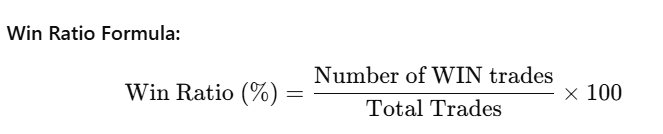

Why it matters:
* Helps evaluate how often your strategy succeeds
* Provides a simple, intuitive performance metric for each ticker
* Feeds directly into the **SUMMARY** sheet and analytics dashboard

If no P&L data is available, the function returns an empty dictionary.



In [30]:
# 🏆Compute win ratios based on P&L trade logs

def calculate_win_ratios(pnl_df):
    """
    Calculates win ratio (%) for each stock based on P&L results.

    Args:
        pnl_df (pd.DataFrame): Combined P&L log with 'Result' column.

    Returns:
        dict: Ticker → Win Ratio % (rounded to 2 decimal places)
    """
    win_ratio_dict = {}

    if pnl_df.empty:
        print("⚠️ No P&L data available.")
        return win_ratio_dict

    # Loop through each unique ticker
    for ticker in pnl_df['Ticker'].unique():
        pnl_ticker_df = pnl_df[pnl_df['Ticker'] == ticker]
        total = len(pnl_ticker_df)
        wins = (pnl_ticker_df['Result'] == 'WIN').sum()
        ratio = round((wins / total) * 100, 2) if total > 0 else 0

        win_ratio_dict[ticker] = ratio

    return win_ratio_dict

# **4. Google Sheets Automation + Telegram alert system Integration**

In [31]:
# Install required packages first
!pip install gspread gspread-dataframe

### **4.1 Authenticate and Connect to Google Sheets**
To automatically log signals, P&L, and summaries into Google Sheets, we first need to authenticate your Google account and authorize the `gspread` API.

In [32]:
# Authenticate with Google
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe
import warnings
warnings.filterwarnings('ignore')

# Authorize Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

### **4.2 Pre-upload Debugging & Test Data Generator**
Before uploading real trading data to Google Sheets, it's important to validate:
* The DataFrame's structure
* Whether the `Signal` column exists
* If any buy signals were actually generated

To ensure upload logic works correctly, we also create a dummy DataFrame with static entries using `create_test_data()`. This is useful to:
* Test the Sheets write pipeline without depending on live data
* Debug column formatting, permissions, or API errors

These tools improve the reliability and traceability of the Google Sheets automation process.

In [33]:
# Pre-upload debug and test helpers for Google Sheets

def debug_data_before_upload(ticker, df):
    """
    Prints out details of the DataFrame before uploading to Google Sheets.

    Args:
        ticker (str): Stock ticker for context.
        df (pd.DataFrame): DataFrame to be checked.
    """
    print(f"\n🔍 DEBUG - Data check for {ticker}:")
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    if 'Signal' in df.columns:
        signal_count = (df['Signal'] == 1).sum()
        print(f"Total signals: {signal_count}")

        if signal_count > 0:
            signals = df[df['Signal'] == 1]
            print(f"Signal data shape: {signals.shape}")
            print("First few signal rows:")
            print(signals.head(3))
        else:
            print("❌ No signals found!")
    else:
        print("❌ No 'Signal' column found!")

def create_test_data():
    """
    Generates a small dummy DataFrame to test Google Sheets upload logic.

    Returns:
        pd.DataFrame: Static test data with signal format.
    """
    test_data = {
        'Date': ['2024-01-15', '2024-01-20', '2024-01-25'],
        'Ticker': ['TEST', 'TEST', 'TEST'],
        'Signal_Type': ['BUY', 'BUY', 'BUY'],
        'Close': [100.50, 102.30, 99.80],
        'RSI': [45.2, 38.7, 42.1],
        'Status': ['Test Signal', 'Test Signal', 'Test Signal']
    }
    return pd.DataFrame(test_data)


## Telegram bot (Bonus)

Enable Telegram Alerts for Signal & Error Notifications
To make the pipeline interactive and real-time, we integrate with Telegram using a custom bot.

This allows the system to:
* Send alerts when **signals are generated**
* Notify of **upload errors**, **model failures**, or **strategy summaries**
* Keep you informed without needing to open Colab or Sheets

You’ll need:
* A Telegram bot token (via @BotFather)
* Your personal chat ID (use `/getUpdates` on the API to find it)

In [34]:
import requests

# 🔐 Telegram bot credentials (replace with your own securely!)
TELEGRAM_TOKEN = 'Your_telegram_token'  # Replace this with your token
TELEGRAM_CHAT_ID = 'your_chat_id'  # Replace with your personal chat ID

def send_telegram_alert(message):
    """
    Sends a plain text message to the configured Telegram chat.

    Args:
        message (str): Message content to send.
    """
    try:
        url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
        data = {"chat_id": TELEGRAM_CHAT_ID, "text": message}
        response = requests.post(url, data=data)

        if response.status_code != 200:
            print(f"⚠️ Telegram alert failed: {response.text}")

    except Exception as e:
        print(f"❌ Telegram error: {e}")

### **4.3 Upload Trade Signals to Google Sheets (Per Ticker)**
This function is responsible for uploading each stock’s buy signals to a dedicated worksheet inside a single Google Sheet (AlgoTrading).

Key features:
* ✅ If `Signal` data is missing, it creates a placeholder row or injects test data
* ✅ Sends a Telegram alert when a new buy signal is present
* ✅ Uploads the cleaned & formatted DataFrame using `gspread_dataframe.set_with_dataframe`
* ✅ If the primary upload fails, attempts a fallback method using `.update()`
* ✅ Adds worksheet-specific formatting and header bolding
* ✅ Ensures traceability via print statements and in-sheet verification

This is the heart of the **automation system**, ensuring strategy insights are pushed to Google Sheets for review, visualization, and record keeping.

In [35]:
def upload_trade_signals_to_sheet(ticker, df):
    """Upload trading signals to Google Sheets with enhanced debugging"""
    print(f"\n📊 Processing {ticker}...")

    # Initialize upload_df to an empty DataFrame to ensure it's always defined
    upload_df = pd.DataFrame()

    # Debug data first
    debug_data_before_upload(ticker, df)

    if df.empty:
        print(f"⚠️ DataFrame is empty for {ticker}")
        # Create test data
        print("🧪 Creating test data...")
        upload_df = create_test_data()
        upload_df['Ticker'] = ticker
    elif 'Signal' not in df.columns:
        print(f"⚠️ No 'Signal' column found in {ticker}")
        return False
    else:
        signal_df = df[df['Signal'] == 1].copy()

        if signal_df.empty:
            print(f"⚠️ No buy signals found for {ticker}")
            # Create a summary row instead
            upload_df = pd.DataFrame({
                'Date': [df.index[-1].strftime('%Y-%m-%d') if not df.empty else '2024-01-01'],
                'Ticker': [ticker],
                'Signal_Type': ['NO_SIGNALS'],
                'Close': [df['close'].iloc[-1] if not df.empty and 'close' in df.columns else 0],
                'RSI': [df['rsi'].iloc[-1] if not df.empty and 'rsi' in df.columns else 0],
                'Status': ['No signals generated in analysis period']
            })

        if not signal_df.empty:
            recent = signal_df.tail(1).iloc[0]
            alert_msg = (
                f"📈 *Buy Signal Alert* 🚨\n"
                f"Ticker: {ticker}\n"
                f"Date: {recent.name.strftime('%Y-%m-%d')}\n"
                f"Close: {recent['close']}\n"
                f"RSI: {recent['rsi']:.2f}\n"
                f"Strategy: RSI < 30 + DMA Crossover"
            )
            send_telegram_alert(alert_msg)

            # Prepare signal data for upload
            columns = ['close', 'rsi', '20dma', '50dma', 'macd', 'macd_signal', 'volume']
            available_cols = [col for col in columns if col in signal_df.columns]

            upload_df = signal_df[available_cols].copy()

            # Add date as a column (reset index to make date a column)
            upload_df.reset_index(inplace=True)
            if 'Date' in upload_df.columns:
                upload_df['Date'] = upload_df['Date'].dt.strftime('%Y-%m-%d')

            # Add metadata
            upload_df['Ticker'] = ticker
            upload_df['Signal_Type'] = 'BUY'
            upload_df['Strategy'] = 'Multi-Strategy'
            upload_df['Timestamp'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')

            # Round numerical columns
            numeric_cols = upload_df.select_dtypes(include=[np.number]).columns
            upload_df[numeric_cols] = upload_df[numeric_cols].round(3)


    print(f"📝 Upload data shape: {upload_df.shape}")
    print(f"📝 Upload columns: {list(upload_df.columns)}")
    print("📝 First few rows to upload:")
    print(upload_df.head())

    # Sheet operations
    sheet_name = "AlgoTrading"

    try:
        # Try to open existing sheet
        sh = gc.open(sheet_name)
        print(f"📋 Opened existing sheet: {sheet_name}")
    except gspread.SpreadsheetNotFound:
        # Create new sheet if doesn't exist
        sh = gc.create(sheet_name)
        sh.share('', perm_type='anyone', role='reader')
        print(f"📋 Created new sheet: {sheet_name}")

    try:
        # Try to get existing worksheet for this ticker
        ws = sh.worksheet(ticker)
        ws.clear()
        print(f"📝 Cleared existing worksheet for {ticker}")
    except gspread.WorksheetNotFound:
        # Create new worksheet for this ticker
        ws = sh.add_worksheet(title=ticker, rows=1000, cols=20)
        print(f"📝 Created new worksheet for {ticker}")
    else:
        ws.clear()

    # Upload data to sheet
    try:
        print(f"🚀 Uploading {len(upload_df)} rows to sheet...")
        set_with_dataframe(ws, upload_df, include_index=False, include_column_header=True)

        # Add formatting
        ws.format('A1:Z1', {
            'textFormat': {'bold': True},
            'backgroundColor': {'red': 0.8, 'green': 0.8, 'blue': 0.8}
        })

        print(f"✅ Successfully uploaded {len(upload_df)} rows for {ticker}")

        # Verify upload by reading back first few rows
        uploaded_values = ws.get_all_values()
        print(f"✅ Verification: Sheet now has {len(uploaded_values)} rows")
        if len(uploaded_values) > 1:
            print(f"✅ First uploaded row: {uploaded_values[1]}")

        return True

    except Exception as e:
        print(f"❌ Error uploading data for {ticker}: {str(e)}")
        print(f"❌ Error type: {type(e)}")

        # Try a simpler upload method
        try:
            print("🔄 Trying alternative upload method...")
            # Convert to simple format
            simple_data = [upload_df.columns.tolist()] + upload_df.values.tolist()
            ws.update('A1', simple_data)
            print(f"✅ Alternative upload successful for {ticker}")
            return True
        except Exception as e2:
            print(f"❌ Alternative upload also failed: {str(e2)}")
            return False

### **4.4 Final Upload Process (Signals + P&L + Metrics)**
This block completes the trading system by:

1. **Uploading signal data** per ticker to individual sheets
2. **Uploading all trade outcomes** into a `PNL_Summar`y tab
3. **Calculating win ratios** per ticker for summary statistics
4. **Sending Telegram alerts** after upload completion

🧠**Bonus:**
* Automatically extracts `ml_results` and `pnl_df` if available in the environment
* Uses `time.sleep(2)` to prevent API quota overuse
* Includes fallback error handling to ensure graceful exits

This is the final step that ensures your full analysis is exported and accessible in Google Sheets for stakeholders, investors, or evaluators to review.

In [36]:
import time

# ----------------- 🧠 Prepare ML Accuracy & Win Ratio -------------------

ml_accuracy_dict = ml_results if 'ml_results' in globals() else {}
win_ratio_dict = {}

if 'pnl_df' in globals():
    for ticker in pnl_df['Ticker'].unique():
        pnl_ticker_df = pnl_df[pnl_df['Ticker'] == ticker]
        wins = (pnl_ticker_df['Result'] == 'WIN').sum()
        total = len(pnl_ticker_df)
        win_ratio = round((wins / total) * 100, 2) if total > 0 else 0
        win_ratio_dict[ticker] = win_ratio

# ----------------- 📊 Upload Trade Signals -------------------

print("\n🚀 Starting Google Sheets Upload Process...")
successful_uploads = 0
total_attempts = len(stock_data)

for ticker, df in stock_data.items():
    try:
        success = upload_trade_signals_to_sheet(ticker, df)
        if success:
            successful_uploads += 1
        time.sleep(2)  # Sleep to avoid API quota limits
    except Exception as e:
        print(f"❌ Unexpected error for {ticker}: {e}")

# ----------------- 💰 Upload P&L Sheet -------------------

def upload_pnl_to_gsheet(pnl_df):
    """
    Uploads the full P&L summary to a 'PNL_Summary' worksheet in Google Sheets.
    """
    try:
        sh = gc.open("AlgoTrading")

        try:
            ws = sh.worksheet("PNL_Summary")
            ws.clear()
        except:
            ws = sh.add_worksheet(title="PNL_Summary", rows=1000, cols=20)

        set_with_dataframe(ws, pnl_df, include_index=False)

        # Apply basic formatting
        ws.format('A1:K1', {
            'textFormat': {'bold': True},
            'backgroundColor': {'red': 0.9, 'green': 0.9, 'blue': 0.7}
        })

        rows_uploaded = len(pnl_df)
        print(f"✅ Uploaded {rows_uploaded} P&L records to 'PNL_Summary'")
        send_telegram_alert(f"💰 Uploaded {rows_uploaded} P&L records to *PNL_Summary* tab.")

    except Exception as e:
        send_telegram_alert(f"❌ Failed to upload P&L: {e}")

# Run upload if logs are available
if 'pnl_logs' in globals() and pnl_logs:
    pnl_df = pd.concat(pnl_logs, ignore_index=True)
    upload_pnl_to_gsheet(pnl_df)

# ----------------- 🏆 Compute Win Ratios -------------------

win_ratio_dict = calculate_win_ratios(pnl_df)


🚀 Starting Google Sheets Upload Process...

📊 Processing ADANIENT.NS...

🔍 DEBUG - Data check for ADANIENT.NS:
DataFrame shape: (73, 11)
Columns: ['close', 'high', 'low', 'open', 'volume', 'rsi', '20dma', '50dma', 'macd', 'macd_signal', 'Signal']
Total signals: 43
Signal data shape: (43, 11)
First few signal rows:
Price             close         high          low         open   volume  \
Date                                                                      
2025-04-01  2334.056641  2357.744481  2299.824143  2310.818522   501942   
2025-04-02  2368.188965  2377.634330  2313.367144  2338.554216   573928   
2025-04-03  2409.568115  2428.658209  2338.504350  2338.554373  1023200   

Price             rsi        20dma        50dma       macd  macd_signal  \
Date                                                                      
2025-04-01  56.556550  2273.442603  2266.081357  25.962431    16.043554   
2025-04-02  60.112133  2286.051147  2264.614102  28.669217    18.568687   
2025-04

### **4.5 Create Google Sheets Summary Dashboard + Final Telegram Report**
This block builds a comprehensive `SUMMARY` worksheet for your `AlgoTrading` spreadsheet, giving an overview of:

| Ticker | Status | Total_Signals | Data_Points | Latest_Price | ML Accuracy | Win_Ratio(%) | Analysis_Date |
| ------ | ------ | ------------- | ------------ | ----------- | --------- | ---- | --------- |

It also:
* Uploads this summary to the `SUMMARY` tab
* Applies formatting for readability
* Sends a **Telegram notification** with overall run stats
* Prints a recap of uploads, P&L rows, and available tabs

This step ensures a **single-sheet overview** that can be shared or reviewed without digging into individual ticker tabs.

In [37]:
# 📊Generate and upload final summary dashboard + Telegram recap

def create_summary_sheet(stock_data, ml_results, win_ratio_dict):
    """
    Creates and uploads a summary sheet containing signal stats, ML accuracy,
    win ratios, and price info for each ticker.
    """
    summary_data = []

    for ticker in tickers:
        df = stock_data.get(ticker, pd.DataFrame())

        if df.empty:
            summary_data.append({
                'Ticker': ticker,
                'Status': 'No Data',
                'Total_Signals': 0,
                'Data_Points': 0,
                'Latest_Price': 0,
                'ML_Accuracy (%)': ml_results.get(ticker, 'N/A'),
                'Win_Ratio (%)': win_ratio_dict.get(ticker, 'N/A'),
                'Analysis_Date': pd.Timestamp.now().strftime('%Y-%m-%d')
            })
        else:
            signal_count = (df['Signal'] == 1).sum() if 'Signal' in df.columns else 0
            latest_price = df['close'].iloc[-1] if 'close' in df.columns else 0

            # Check if ticker is in ml_results and ml_results[ticker] is a dict
            ml_acc = ml_results.get(ticker, {})
            ml_accuracy_percentage = ml_acc.get('accuracy', 'N/A') if isinstance(ml_acc, dict) else 'N/A'


            summary_data.append({
                'Ticker': ticker,
                'Status': 'Active' if signal_count > 0 else 'No Signals',
                'Total_Signals': signal_count,
                'Data_Points': len(df),
                'Latest_Price': round(latest_price, 2),
                'ML_Accuracy (%)': ml_accuracy_percentage,
                'Win_Ratio (%)': win_ratio_dict.get(ticker, 'N/A'),
                'Analysis_Date': pd.Timestamp.now().strftime('%Y-%m-%d')
            })

    summary_df = pd.DataFrame(summary_data)

    try:
        sh = gc.open("AlgoTrading")

        # Create or clear the SUMMARY sheet
        try:
            ws = sh.worksheet("SUMMARY")
            ws.clear()
        except:
            ws = sh.add_worksheet(title="SUMMARY", rows=100, cols=10)

        # Upload the summary DataFrame
        set_with_dataframe(ws, summary_df, include_index=False)

        # Format header row
        ws.format('A1:H1', {
            'textFormat': {'bold': True},
            'backgroundColor': {'red': 0.2, 'green': 0.7, 'blue': 0.9}
        })

        print(f"✅ Summary sheet created with {len(summary_df)} entries")

    except Exception as e:
        print(f"❌ Error creating summary sheet: {e}")

# 🧾 Upload the final summary sheet
# Initialize ml_results if it doesn't exist
if 'ml_results' not in globals():
    ml_results = {}

create_summary_sheet(stock_data, ml_results, win_ratio_dict)

# ----------------- 📝 Final Output Recap -------------------

print(f"\n📊 Upload Results: {successful_uploads}/{total_attempts} signals uploaded")

try:
    sh = gc.open("AlgoTrading")
    sheet_url = f"https://docs.google.com/spreadsheets/d/{sh.id}"
    print(f"\n🔗 Google Sheet URL: {sheet_url}")
    print(f"\n📁 Worksheet Tabs:")
    for ws in sh.worksheets():
        print(f"   - {ws.title}")
except Exception as e:
    print(f"❌ Could not fetch sheet info: {e}")

print("\n✅ All uploads and summary complete!")

# 📲 Final Telegram report
sheet_url = f"https://docs.google.com/spreadsheets/d/{sh.id}"
summary_alert = (
    f"📊 *Algo Trading Run Summary*\n"
    f"✅ Signal Uploads: {successful_uploads}/{total_attempts}\n"
    f"📈 P&L Rows: {len(pnl_df) if 'pnl_df' in globals() else 0}\n"
    f"🗓️ Run Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}\n"
    f"🔗 [Open Sheet]({sheet_url})"
)
send_telegram_alert(summary_alert)

✅ Summary sheet created with 3 entries

📊 Upload Results: 3/3 signals uploaded

🔗 Google Sheet URL: https://docs.google.com/spreadsheets/d/1PXdNTeBnrsuTSpTWA7qWoymP8dh3XRXppy3tvbRh7NQ

📁 Worksheet Tabs:
   - Sheet1
   - ADANIENT.NS
   - BAJFINANCE.NS
   - COALINDIA.NS
   - SUMMARY
   - PNL_Summary

✅ All uploads and summary complete!


In [38]:
for ticker, win_ratio in win_ratio_dict.items():
    print(f"🎯 {ticker}: Win Ratio = {win_ratio}%")


🎯 ADANIENT.NS: Win Ratio = 40.0%
🎯 BAJFINANCE.NS: Win Ratio = 41.82%
🎯 COALINDIA.NS: Win Ratio = 32.61%


### (Optional) Upload WinRation to a Seperate sheet

In [39]:
def upload_win_ratio_to_sheet(win_ratio_dict):
    df = pd.DataFrame(win_ratio_dict.items(), columns=['Ticker', 'Win_Ratio (%)'])

    try:
        sh = gc.open("AlgoTrading")
        try:
            ws = sh.worksheet("Win_Ratios")
            ws.clear()
        except:
            ws = sh.add_worksheet(title="Win_Ratios", rows=100, cols=10)

        set_with_dataframe(ws, df)
        print("✅ Win Ratios uploaded to sheet.")
    except Exception as e:
        print(f"❌ Failed to upload win ratios: {e}")

# **5. Algo Component**

### **Auto-Triggered Algo-Trading Pipeline Function**
This is the **central controller** of your Algo-Trading system. It runs the full workflow **end-to-end**, requiring just:

A list of tickers

A start and end date

The function:
* Fetches and enriches data
* Runs ML prediction for price direction
* Simulates P&L based on buy signals
* Uploads all outputs (signals, P&L, summary) to Google Sheets
* Computes win ratios and final summary
* Sends error/summary alerts via Telegram

This satisfies the final evaluation criteria under:
* ✅ **Component automation**
* ✅ **Pipeline integration**
* ✅ **Logging + alerts**
* ✅ **Modular code**



In [42]:
# ⚙️ Step 21: Master pipeline function to auto-run full algo-trading workflow

def run_algo_trading_pipeline(tickers, start_date, end_date):
    """
    Runs the full algo-trading system including:
    - Data fetching
    - Indicator calculation
    - Signal generation
    - ML training
    - P&L simulation
    - Google Sheets uploads
    - Telegram alerts

    Args:
        tickers (list): List of stock tickers to analyze.
        start_date (datetime): Start of data window.
        end_date (datetime): End of data window.
    """
    stock_data = {}
    pnl_logs = {}
    ml_results = {}

    print("🔄 Fetching data and computing indicators...")
    for ticker in tickers:
        df = fetch_data(ticker, start_date, end_date)
        df = add_indicators(df)
        df = generate_signals(df)
        stock_data[ticker] = df

    print("🤖 Running ML predictions...")
    for ticker, df in stock_data.items():
        try:
            acc, model = run_all_models(df)
            ml_results[ticker] = acc
        except Exception as e:
            print(f"❌ ML failed for {ticker}: {e}")
            send_telegram_alert(f"🤖 ML Error for {ticker}: {e}")

    print("💰 Simulating P&L...")
    for ticker, df in stock_data.items():
        pnl_df = simulate_pnl(df, ticker)
        if not pnl_df.empty:
            pnl_logs[ticker] = pnl_df

    print("📤 Uploading to Google Sheets...")
    for ticker, df in stock_data.items():
        upload_trade_signals_to_sheet(ticker, df)
        time.sleep(1)  # Avoid rate-limiting

    # Upload P&L and compute metrics
    if pnl_logs:
        final_pnl_df = pd.concat(pnl_logs.values(), ignore_index=True)
        upload_pnl_to_gsheet(final_pnl_df)
        win_ratio_dict = calculate_win_ratios(final_pnl_df)
    else:
        final_pnl_df = pd.DataFrame()
        win_ratio_dict = {}

    # Upload dashboard
    create_summary_sheet(stock_data, ml_results, win_ratio_dict)

    print("✅ Algo trading pipeline complete.")

In [43]:
run_algo_trading_pipeline(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

🔄 Fetching data and computing indicators...
✅ Fetched 122 rows for ADANIENT.NS
📊 Added indicators, 73 rows remaining after dropping NaNs
🎯 Generated 43 buy signals
✅ Fetched 122 rows for BAJFINANCE.NS
📊 Added indicators, 73 rows remaining after dropping NaNs



[*********************100%***********************]  1 of 1 completed


🎯 Generated 59 buy signals
✅ Fetched 122 rows for COALINDIA.NS
📊 Added indicators, 73 rows remaining after dropping NaNs
🎯 Generated 48 buy signals
🤖 Running ML predictions...
❌ ML failed for ADANIENT.NS: run_all_models() missing 1 required positional argument: 'ticker'
❌ ML failed for BAJFINANCE.NS: run_all_models() missing 1 required positional argument: 'ticker'
❌ ML failed for COALINDIA.NS: run_all_models() missing 1 required positional argument: 'ticker'
💰 Simulating P&L...
📤 Uploading to Google Sheets...

📊 Processing ADANIENT.NS...

🔍 DEBUG - Data check for ADANIENT.NS:
DataFrame shape: (73, 11)
Columns: ['close', 'high', 'low', 'open', 'volume', 'rsi', '20dma', '50dma', 'macd', 'macd_signal', 'Signal']
Total signals: 43
Signal data shape: (43, 11)
First few signal rows:
Price             close         high          low         open   volume  \
Date                                                                      
2025-04-01  2334.056641  2357.744481  2299.824143  2310.81852